In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.FeatExtModels import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Data

In [2]:
DATA = np.load('./Data/AsanTRSet.npy')

#### Env setting

In [3]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
### Model checkpoint
ModelSaveSameName = save_path+'FeatExtM.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=500)

LatDim = 2
SigDim = DATA.shape[1]
MaskingRate = 0.025
GaussStd1 = 0.002
GaussStd2 = 0.1

### Vae Loss; RecMSE and KL Divergence¶

In [4]:
EncModel = EncoderModel(SigDim, Type = 'FX', LatDim= LatDim, MaskingRate = MaskingRate, GaussStd1 = GaussStd1, GaussStd2 = GaussStd2, training=True)
FeExModel = FeatExtractModel(SigDim=SigDim)
DecModel = DecoderModel(SigDim=SigDim)
VaeSFModel = VaeModel(EncModel,FeExModel, DecModel )
VaeSFModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})

### Vae Loss; KL Divergence
Z_Sampled, Z_Log_Sigma = EncModel.get_layer('Z_Mean_FX').output,EncModel.get_layer('Z_Log_Sigma_FX').output
kl_Loss = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss = tf.reduce_mean(kl_Loss )
VaeSFModel.add_loss(kl_Loss )
VaeSFModel.add_metric(kl_Loss, 'KL_D')

VaeSFModel.summary()

Model: "VaeSFModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame (TFOpLambda)    (None, 10, 100)      0           input_1[0][0]                    
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 10, 100)      0           tf.signal.frame[0][0]            
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (3,)                 0           gaussian_noise[0][0]             
_________________________________________________________________________________________

In [5]:
VaeSFModel.load_weights(ModelSaveSameName)
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

VaeSFModel.fit(DATA[:], DATA[:], batch_size=1000, epochs=600, shuffle=True, validation_split=0.2, callbacks=[ModelSave, EarlyStop])

Epoch 1/600
320/320 [==============================] - 78s 208ms/step - loss: 0.0111 - mse: 9.8075e-04 - KL_D: 0.0100 - val_loss: 0.0108 - val_mse: 8.4859e-04 - val_KL_D: 0.0100

Epoch 00001: val_mse improved from inf to 0.00085, saving model to ./Results\FeatExtM.hdf5
Epoch 2/600
320/320 [==============================] - 62s 195ms/step - loss: 0.0109 - mse: 8.4787e-04 - KL_D: 0.0100 - val_loss: 0.0109 - val_mse: 8.5193e-04 - val_KL_D: 0.0100

Epoch 00002: val_mse did not improve from 0.00085
Epoch 3/600
320/320 [==============================] - 62s 194ms/step - loss: 0.0109 - mse: 8.5183e-04 - KL_D: 0.0100 - val_loss: 0.0109 - val_mse: 8.5277e-04 - val_KL_D: 0.0101

Epoch 00003: val_mse did not improve from 0.00085
Epoch 4/600
320/320 [==============================] - 63s 196ms/step - loss: 0.0109 - mse: 8.4664e-04 - KL_D: 0.0100 - val_loss: 0.0108 - val_mse: 8.5276e-04 - val_KL_D: 0.0100

Epoch 00004: val_mse did not improve from 0.00085
Epoch 5/600
320/320 [======================


KeyboardInterrupt



### Setting for post analysis

In [17]:
EncModel = EncoderModel(SigDim, Type = 'FX', LatDim= 2, MaskingRate = 0.025,GaussStd1 = 0.002, GaussStd2 = 0.1, training=True)
FeExModel = FeatExtractModel(SigDim=SigDim)
DecModel = DecoderModel(SigDim=SigDim)
VaeSFModel = VaeModel(EncModel,FeExModel, DecModel )

### Vae Loss; KL Divergence
Z_Sampled, Z_Log_Sigma = EncModel.get_layer('Z_Mean_FX').output,EncModel.get_layer('Z_Log_Sigma_FX').output
kl_Loss = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss = tf.reduce_mean(kl_Loss )
VaeSFModel.add_loss(kl_Loss )
VaeSFModel.add_metric(kl_Loss, 'KL_D')

VaeSFModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})
VaeSFModel.load_weights(ModelSaveSameName)
#VaeSFModel.evaluate(DATA[:], DATA[:], batch_size=2000, verbose=1)


### Post evaluation

In [18]:
VaeSFModel.evaluate(DATA[:], DATA[:], batch_size=2000, verbose=1)

200/200 [==============================] - 20s 71ms/step - loss: 0.0110 - mse: 0.0010 - KL_D: 0.0100


[0.011029090732336044, 0.0010252054780721664, 0.0100038917735219]

#### Rec pred by zMean

In [19]:
VaeSFModel.load_weights(ModelSaveSameName)
Pred =VaeSFModel.predict(DATA[:], batch_size=3000, verbose=1)
np.mean((DATA[:]- Pred)**2)

134/134 [==============================] - 16s 97ms/step


0.0010230156

#### Components pred

In [20]:
VaeSFModel.load_weights(ModelSaveSameName)

HpSig_21 = FeExModel.get_layer('HpSig_21').output
LpSig_21 = FeExModel.get_layer('LpSig_21').output
HpSig_22 = FeExModel.get_layer('HpSig_22').output
LpSig_22 = FeExModel.get_layer('LpSig_22').output

LHFs = FeExModel.get_layer('LHFs').output
LHBs = FeExModel.get_layer('LHBs').output

LatM = Model(FeExModel.input, [HpSig_21, LpSig_21, HpSig_22, LpSig_22 ])
ParaM = Model(FeExModel.input, [LHFs, LHBs ])


Pred_ZMean = Model(EncModel.input, EncModel.get_layer('Z_Mean_FX').output).predict(DATA[:10])
PredLat = LatM.predict([DATA[:10],Pred_ZMean] )
PredPara = ParaM.predict([DATA[:10],Pred_ZMean] )
Pred =VaeSFModel.predict(DATA[:10])


#### Variational pred

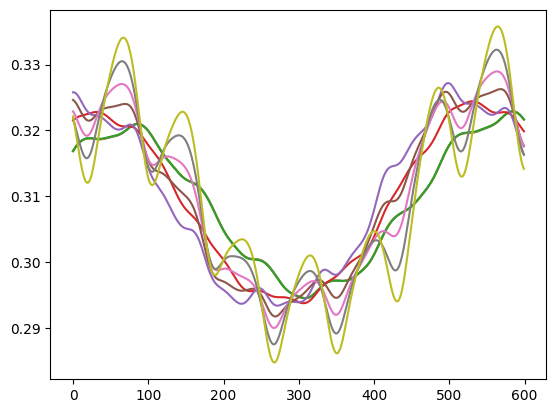

In [21]:
Pred_ZSampled = np.array([np.linspace(-30, 30, 10), np.linspace(-30, 30, 10)]).T
DataSample = np.tile(DATA[1:2].T, 10).T
PredLat = LatM.predict([DataSample,Pred_ZSampled] )

idx = 3
#plt.plot(DATA[idx])
for i in range(9):
    plt.plot(PredLat[idx][i, :1000, 0])
    #print(PredLat[i].shape)

In [12]:
PredLat[0].shape

(10, 300, 1)

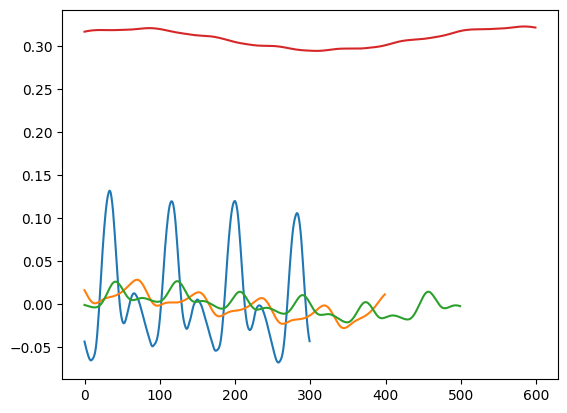

In [22]:
idx = 0
#plt.plot(DATA[idx])
for i in range(4):
    plt.plot(PredLat[i][idx, :1000, 0])
    #print(PredLat[i].shape)


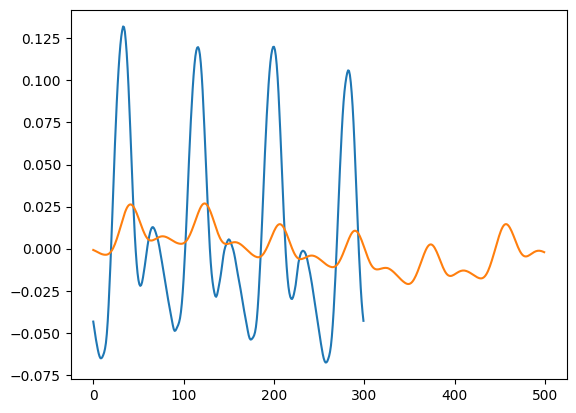

In [23]:
idx = 0
plt.plot(PredLat[0][idx, :1000, 0])
plt.plot(PredLat[2][idx, :1000, 0])


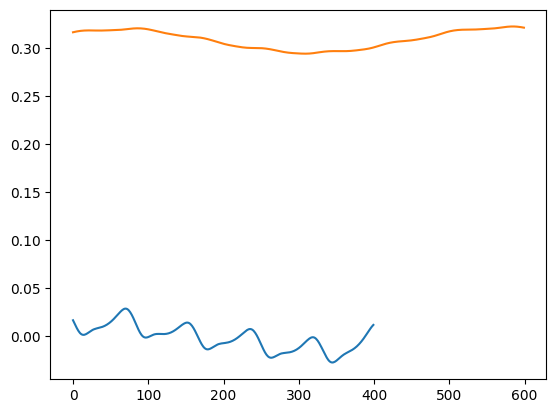

In [24]:
plt.plot(PredLat[1][idx, :, 0])
plt.plot(PredLat[3][idx, :, 0])


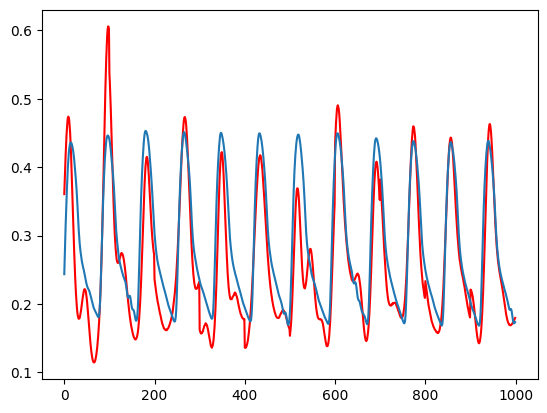

In [25]:
idx= 6
plt.plot(Pred[idx], c='red')
plt.plot(DATA[idx])
